# “中国软件杯”大学生软件设计大赛二等奖开源代码——基于深度学习的企业实体识别

## 比赛简介：
为贯彻落实《国家中长期教育改革和发展规划纲要(2010-2020年)》，科学引导高校青年学子积极参加科研活动，切实增强自主创新能力和实际动手能力，实现应用型人才培养和产业需求的有效衔接，推动我国软件和信息技术服务业又好又快发展，工业和信息化部、教育部和江苏省人民政府共同主办了面向中国高校及广大海外院校在校学生(含高职)的纯公益性软件设计大赛。其中普通本科高校600余所，高职院校200余所，211、985高校百余所，累计近万名大学生参赛。

## 赛题介绍：
> 着深度学习技术的发展，文字识别与自然语言处理近年来受到广泛关注。结合文字识别与自然语言处理技术解决传统方法无法处理的问题，成为企业提高自身竞争力的重要利器。
本赛题要求使用基于深度学习的文字识别与自然语言处理技术，识别商铺广告牌图片中的文字，从识别出的文字中提取出商铺名称。此系统涉及文字检测、文字识别、命名实体识别三种技术。

## 业务场景：
> 企业实体识别主要应用在我们目前业务系统中的查证功能。查证功能的主要作用是将用户拍摄的店铺照片经过OCR识别后进行店铺名称的提取，然后通过店铺名称查询证照库，获取该店铺办理过的所有证照信息，方便用户进一步了解该店铺。在日常应用中，例如外出就餐时利用我们的系统随手拍摄要就餐的饭店门脸，系统会自动检测该饭店证照是否齐全以及所办证照的详细信息，方便用户做出就餐决策。

## 涉及工具：
### 1. PaddlePaddle原生框架：
百度出品的深度学习平台飞桨（PaddlePaddle）是主流深度学习框架中一款完全国产化的产品，与Google TensorFlow、Facebook Pytorch齐名。2016 年飞桨正式开源，是国内首个全面开源开放、技术领先、功能完备的产业级深度学习平台。相比国内其他平台，飞桨是一个功能完整的深度学习平台，也是唯一成熟稳定、具备大规模推广条件的深度学习平台。
### 2. PaddleOCR工具库：
PaddleOCR是一个与OCR相关的开源项目，不仅支持超轻量级中文OCR预测模型，总模型仅8.6M（单模型支持中英文数字组合识别、竖排文本识别、长文本识别，其中检测模型DB（4.1M）+识别模型CRNN（4.5M）），而且提供多种文本检测训练算法（EAST、DB）和多种文本识别训练算法（Rosetta、CRNN、STAR-Net、RARE）。
### 3. Paddle-Lite轻量级推理框架：
Paddle Lite是飞桨基于Paddle Mobile全新升级推出的端侧推理引擎，在多硬件、多平台以及硬件混合调度的支持上更加完备，为包括手机在内的端侧场景的AI应用提供高效轻量的推理能力，有效解决手机算力和内存限制等问题，致力于推动AI应用更广泛的落地

![](https://ai-studio-static-online.cdn.bcebos.com/3cb25eba88674aca819370a36f5ea70d3e15a7f330d34acc96733cf9ab8b5be9)

## 设计思路：

![](https://ai-studio-static-online.cdn.bcebos.com/7cfffecf5e19408d98f6d05011573c3afbb52ac36e66432bb2373b642678fdb6)

## 效果演示：
### 1. 手机APP：

![](https://ai-studio-static-online.cdn.bcebos.com/166cb4689d474b54a72960ea2b5251578d45e615f93d45ee83d8d4a4176379cd)

### 2. PC端软件：

![](https://ai-studio-static-online.cdn.bcebos.com/e7ea8cf4bb734490ba5c146d8484c796d76b1fde6ff64b82aeb1281383779e0d)


## Step-1 调用PaddleOCR进行文本检测

In [ ]:
!pip install shapely
!pip install pyclipper

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 1.0MB 13.1MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 133kB 12.5MB/s eta 0:00:01


In [ ]:
from PIL import Image, ImageDraw, ImageFont
from numpy import random
import paddlehub as hub
import numpy as np
import paddle.fluid as fluid

class Detector(object):
    def __init__(self):
        # 加载移动端预训练模型
        # self.ocr = hub.Module(name='chinese_ocr_db_crnn_mobile')
        # 服务端可以加载大模型，效果更好
        self.ocr = hub.Module(name='chinese_ocr_db_crnn_server')

    def feedCap(self, np_images, vis=True):

        results = self.ocr.recognize_text(
            # 图片数据，ndarray.shape 为 [H, W, C]，BGR格式；
            images=[np_images],
            use_gpu=True,            # 是否使用 GPU；若使用GPU，请先设置CUDA_VISIBLE_DEVICES环境变量
            visualization=False,      # 是否将识别结果保存为图片文件；
            box_thresh=0.5,           # 检测文本框置信度的阈值；
            text_thresh=0.5)

        img = Image.fromarray(np_images[:, :, [2, 1, 0]])
        draw = ImageDraw.Draw(img)  # 图片上打印
        txt = []

        for result in results:
            data = result['data']
            for infomation in data:
                if vis:
                    for i in range(5):
                        pos = [(v[0]+i, v[1]+i)
                               for v in infomation['text_box_position']]
                        draw.polygon(pos, outline=(0, 255, 0))
                txt.append(infomation['text'])

        # img = np.array(img)[:, :, [2, 1, 0]]
        return img, txt

创建实例并查看图像

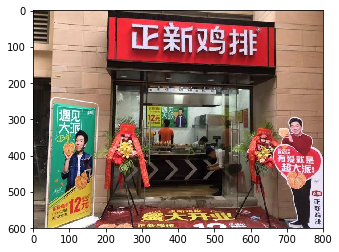

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

img = cv2.imread('21.jpg')
plt.imshow(img[:, :, [2, 1, 0]])

使用OCR模型进行文本检测和识别

[2020-11-04 10:05:29,624] [    INFO] - Installing chinese_ocr_db_crnn_server module
[2020-11-04 10:05:29,627] [    INFO] - Module chinese_ocr_db_crnn_server already installed in /home/aistudio/.paddlehub/modules/chinese_ocr_db_crnn_server
[2020-11-04 10:05:30,104] [    INFO] - Installing chinese_text_detection_db_server module-1.0.2
[2020-11-04 10:05:30,107] [    INFO] - Module chinese_text_detection_db_server-1.0.2 already installed in /home/aistudio/.paddlehub/modules/chinese_text_detection_db_server


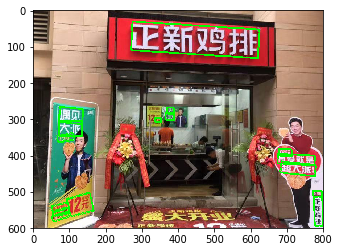

['正新鸡排', '遇见', '见', '天派', '天派', '元', 'Bh!', '31G元', '有爱就是', '超大派', '正新', '12元', '正新鸡排', '正新鸡排', '门市价18元', '再饮科1']


In [ ]:
ocr_model = Detector()

result, txt = ocr_model.feedCap(img)
plt.imshow(result)
plt.show()
print(txt)

## Step-2 使用百度地图API爬取店铺名称（正样本）

这一步需要首先在百度地图开放平台注册并且申请API

![](https://ai-studio-static-online.cdn.bcebos.com/2a6f322f5ab146fc985014f5aab5faf36a3e0a59b8e64cc0bb0ca4f04d524908)

### 使用Python接口爬取店铺名

In [ ]:
import requests
from tqdm import tqdm


def baidu_map_search():
    # 注册->新建应用 http://lbsyun.baidu.com/
    apk_key = "你申请的应用AK"

    url = "http://api.map.baidu.com/place/v2/search"

    types = [
        '酒店', '美食', '购物', '生活服务', '丽人', '休闲娱乐',
        '运动健身', '教育培训', '文化传媒', '医疗', '汽车服务'
    ]

    with open('region.txt', 'r', encoding='utf-8') as f:
        regions = f.read()
        regions = regions.split('、')

    region_index = 0
    type_index = 0
    page = 0
    f = open('pos_{}.txt'.format(type_index), 'w', encoding='utf-8')
    while True:
        params = {
            "query": types[type_index],
            "output": "json",
            "ak": apk_key,
            "region": regions[region_index],
            "page_size": 20,
            "page_num": page,
            "scope": 1,
            "radius": 10000
        }

        page += 1

        response = requests.get(url, params)
        result = response.json()
        status = result.get("status")
        message = result.get("message")

        if status != 0 and status != 2:
            raise Exception(message)
        data = result.get("results", {})
        if len(data) == 0:
            region_index += 1
            page = 0
        if region_index == len(regions):
            region_index = 0
            type_index += 1
            f.close()
            f = open('pos_{}.txt'.format(type_index), 'w', encoding='utf-8')
        if type_index == len(types):
            f.close()
            return

        print('{} {} page:{} num:{}'.format(
            regions[region_index], types[type_index], page, len(data)))
        for row in data:
            item = {
                "name": row.get("name", "")
            }
            for k, v in item.items():
                if '市' in v:
                    continue
                f.write(v.split('(')[0]+'\n')


if True:

    baidu_map_search()

    results = []
    for i in range(11):
        with open('pos_{}.txt'.format(i), 'r', encoding='utf-8') as f:
            data = f.read().splitlines()
            for v in tqdm(data):
                if v[0] >= 'A' and v[0] <= 'z':
                    continue
                if '州' in v or '县' in v or '市' in v or '区' in v or '盟' in v or '厕' in v:
                    continue
                if v in results:
                    continue
                results.append(v)
    
    with open('pos_ch.txt', 'w', encoding='utf-8') as f:
        for v in results:
            f.write(v+'\n') 
    
    print(len(results))

负样本我们从百度&香港大学提出新的中文街景数据——C-SVT数据集中进行采集，收集部分店铺广告等接近店铺名称的文本作为负样本参与训练。

![](https://ai-studio-static-online.cdn.bcebos.com/4dd54b3b168b4352bd04cdd9f8b7cd0cf35e593f8f824b26a6120cee5e7a4957)

这里我们将正负样本处理成词向量，保存在txt中。

![](https://ai-studio-static-online.cdn.bcebos.com/96c79339de2a492eb5850c2e459c32e01dded256cf0a4710a7ea983f7f451049)

## Step-3 训练实体识别（二分类）模型

这里我们构建一个BiLSTM模型。

![](https://ai-studio-static-online.cdn.bcebos.com/a022b08d31f54486adcffffdb0c90ae8de244343a5124cd289de15e3337bab80)


### 训练模型

In [ ]:
import numpy as np
import paddle
import paddle.fluid as fluid
from multiprocessing  import cpu_count
import matplotlib.pyplot as mp 

def mydata_mapper(sample):
    data,label=sample
    val=[int(w) for w in data.split(',')]
    return val,int(label)

##读取器
def train_reader(train_data_file):
    def reader():
        with open(train_data_file,'r',encoding='utf8') as f:
            lines=f.readlines()
            np.random.shuffle(lines)
            for line in lines:
                data,label=line.split('\t')
                yield data,label
    return fluid.io.xmap_readers(mydata_mapper,reader,cpu_count(),1024)

def test_reader(test_data_file):
    def reader():
        with open(test_data_file,'r',encoding='utf8') as f:
            lines=f.readlines()
            np.random.shuffle(lines)
            for line in lines:
                data,label=line.split('\t')
                yield data,label
    return fluid.io.xmap_readers(mydata_mapper,reader,cpu_count(),1024)

#模型TextCNN
def cnn_net(data,dict_dim,class_dim,emb_dim=128,hid_dim=128,hid_dim2=98):
    #embedding 层
    emb=paddle.fluid.layers.embedding(input=data,size=[dict_dim,emb_dim])
    conv_1=fluid.nets.sequence_conv_pool(input=emb,filter_size=2,num_filters=hid_dim,act='tanh',pool_type='sqrt')
    conv_2=fluid.nets.sequence_conv_pool(input=emb,filter_size=3,num_filters=hid_dim2,act='tanh',pool_type='sqrt')
    output=fluid.layers.fc(input=[conv_1,conv_2],size=class_dim,act='softmax')
    return output

# 定义长短期记忆网络
def lstm_net(ipt, input_dim):
    # 嵌入层
    emb = fluid.layers.embedding(input=ipt, size=[input_dim, 32], is_sparse=True) # 以数据的IDs作为输入
        # 全连接层
    fc1 = fluid.layers.fc(input=emb, size=32)
        # 进行长短期记忆操作
    lstm1, _ = fluid.layers.dynamic_lstm(input=fc1, #返回：隐藏状态（hidden state），LSTM的神经元状态
                                         size=32) #size=4*hidden_size
    # 第一个最大序列池
    fc2 = fluid.layers.sequence_pool(input=fc1, pool_type='max')    
    # 第二个最大序列池
    lstm2 = fluid.layers.sequence_pool(input=lstm1, pool_type='max')    
    # 输出层
    out = fluid.layers.fc(input=[fc2, lstm2], size=2, act='softmax') # 以softmax作为全连接的输出层，大小为2,也就是正负面
    
    return out

2020-11-04 16:28:28,615-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-11-04 16:28:29,038-INFO: generated new fontManager


2911
pass_id:0,batch_id0,train_cost0.695966,train_acc0.453125
pass_id:0,batch_id100,train_cost0.377287,train_acc0.875000
pass_id:0,avg_test_cost0.418841,avg_test_acc0.833163
保存模型完成！


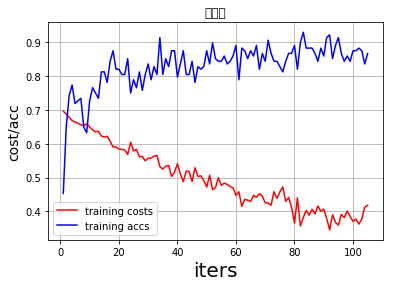

pass_id:1,batch_id0,train_cost0.318345,train_acc0.898438
pass_id:1,batch_id100,train_cost0.340376,train_acc0.835938
pass_id:2,batch_id0,train_cost0.267409,train_acc0.906250
pass_id:2,batch_id100,train_cost0.225390,train_acc0.921875
pass_id:3,batch_id0,train_cost0.259123,train_acc0.906250
pass_id:3,batch_id100,train_cost0.267710,train_acc0.906250
pass_id:4,batch_id0,train_cost0.291620,train_acc0.843750
pass_id:4,batch_id100,train_cost0.186895,train_acc0.914062
pass_id:4,avg_test_cost0.316026,avg_test_acc0.864413
保存模型完成！


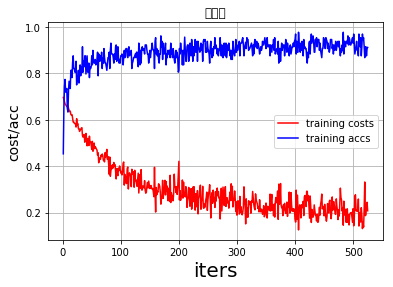

pass_id:5,batch_id0,train_cost0.204422,train_acc0.921875
pass_id:5,batch_id100,train_cost0.122360,train_acc0.968750
pass_id:6,batch_id0,train_cost0.159457,train_acc0.921875
pass_id:6,batch_id100,train_cost0.182654,train_acc0.921875
pass_id:7,batch_id0,train_cost0.133478,train_acc0.953125
pass_id:7,batch_id100,train_cost0.215049,train_acc0.898438
pass_id:8,batch_id0,train_cost0.156236,train_acc0.945312
pass_id:8,batch_id100,train_cost0.199889,train_acc0.906250
pass_id:8,avg_test_cost0.306875,avg_test_acc0.865317
保存模型完成！


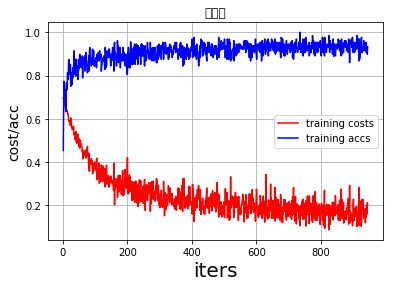

pass_id:9,batch_id0,train_cost0.174466,train_acc0.898438
pass_id:9,batch_id100,train_cost0.167667,train_acc0.953125
pass_id:10,batch_id0,train_cost0.222537,train_acc0.906250
pass_id:10,batch_id100,train_cost0.167353,train_acc0.945312
pass_id:11,batch_id0,train_cost0.161735,train_acc0.937500
pass_id:11,batch_id100,train_cost0.114671,train_acc0.937500
pass_id:12,batch_id0,train_cost0.195462,train_acc0.937500
pass_id:12,batch_id100,train_cost0.120531,train_acc0.953125
pass_id:12,avg_test_cost0.309831,avg_test_acc0.865630
保存模型完成！


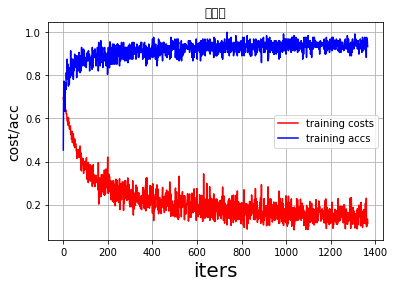

pass_id:13,batch_id0,train_cost0.119873,train_acc0.937500
pass_id:13,batch_id100,train_cost0.175883,train_acc0.937500
pass_id:14,batch_id0,train_cost0.112728,train_acc0.960938
pass_id:14,batch_id100,train_cost0.134914,train_acc0.953125
pass_id:15,batch_id0,train_cost0.116645,train_acc0.953125
pass_id:15,batch_id100,train_cost0.156632,train_acc0.929688
pass_id:16,batch_id0,train_cost0.104924,train_acc0.960938
pass_id:16,batch_id100,train_cost0.132893,train_acc0.945312
pass_id:16,avg_test_cost0.311150,avg_test_acc0.865630
保存模型完成！


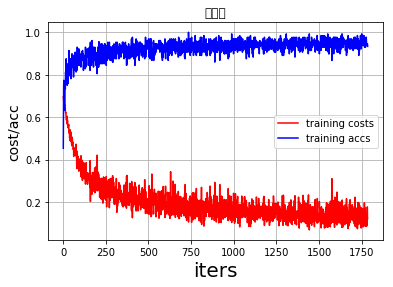

pass_id:17,batch_id0,train_cost0.143791,train_acc0.953125
pass_id:17,batch_id100,train_cost0.092052,train_acc0.976562
pass_id:18,batch_id0,train_cost0.116342,train_acc0.968750
pass_id:18,batch_id100,train_cost0.138811,train_acc0.929688
pass_id:19,batch_id0,train_cost0.133741,train_acc0.937500
pass_id:19,batch_id100,train_cost0.148492,train_acc0.921875
pass_id:20,batch_id0,train_cost0.113202,train_acc0.968750
pass_id:20,batch_id100,train_cost0.114101,train_acc0.945312
pass_id:20,avg_test_cost0.312817,avg_test_acc0.870767
保存模型完成！


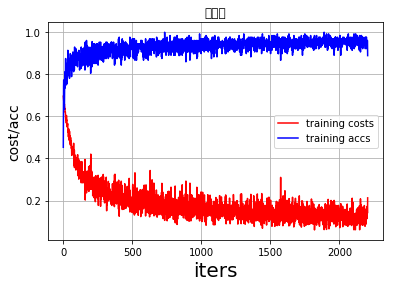

In [ ]:
import os

def get_dict_len():
    with open('dict_file.txt','r',encoding='utf-8') as f:
        lines=f.readlines()
        return len(eval(lines[0]))

poch = 20
model_save_path='work/new_classify_word/'
words=fluid.layers.data(name='x',shape=[1],dtype='int64',lod_level=1)
label=fluid.layers.data(name='label',shape=[1],dtype='int64')
lengt=get_dict_len()
print(lengt)

# 获取文本CNN
# model=cnn_net(words,lengt,2)

# # 获取长短期记忆网络
model = lstm_net(words, lengt)

cost=fluid.layers.cross_entropy(input=model,label=label)

avg_cost=fluid.layers.mean(cost)
acc=fluid.layers.accuracy(input=model,label=label)

optomizer=fluid.optimizer.AdagradOptimizer(learning_rate=0.005)
opt=optomizer.minimize(avg_cost)
test_program=fluid.default_main_program().clone(for_test=True)
use_cuda=False
place=fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace() 
exe=fluid.Executor(place)
exe.run(fluid.default_startup_program())
my_train_reader=paddle.batch(train_reader('train_file.txt'),batch_size=128)
my_test_reader=paddle.batch(test_reader('test_file.txt'),batch_size=128)

my_feeder=fluid.DataFeeder(place=place,feed_list=[words,label])
accs=[]
costs=[]
batchs=[]
times=0
for pass_id in range(poch+1):
    for batch_id,data in enumerate(my_train_reader()):
        #print(data)
        times+=1
        train_cost,train_acc=exe.run(program=fluid.default_main_program(),feed=my_feeder.feed(data),fetch_list=[avg_cost,acc])
        if batch_id%100==0:
            print('pass_id:%d,batch_id%d,train_cost%f,train_acc%f'%(pass_id,batch_id,train_cost[0],train_acc[0]))
        accs.append(train_acc[0])
        costs.append(train_cost[0])
        batchs.append(times)
    test_costs=[]
    test_accs=[]
    for batch_id,data in enumerate(my_test_reader()):
        test_cost,test_acc=exe.run(program=test_program,
                                feed=my_feeder.feed(data),
                                fetch_list=[avg_cost,acc])
        test_costs.append(test_cost[0])
        test_accs.append(test_acc[0])
        avg_test_cost=sum(test_costs)/len(test_costs)
        avg_test_acc=sum(test_accs)/len(test_accs)
        
    if not os.path.exists(model_save_path):
        os.mkdir(model_save_path)
    
    if pass_id % 4 == 0:
        print('pass_id:%d,avg_test_cost%f,avg_test_acc%f'%(pass_id,avg_test_cost,avg_test_acc))
        fluid.io.save_inference_model(model_save_path,
                                        feeded_var_names=[words.name],
                                        target_vars=[model],
                                        executor=exe)
        print('保存模型完成！')
        mp.title('训练图')
        mp.xlabel('iters',fontsize=20)
        mp.ylabel('cost/acc',fontsize=14)
        mp.plot(batchs,costs,color='red',label='training costs')
        mp.plot(batchs,accs,color='blue',label='training accs')
        mp.legend()
        mp.grid()
        mp.savefig('training.jpg')
        mp.show()

In [ ]:
fluid.io.save_inference_model(dirname="infer.model", feeded_var_names=["x"], target_vars=[model], executor=exe)
print("保存成功!")

### 测试模型

In [8]:
import paddle.fluid as fluid
import numpy as np

def get_data(s):
    with open('dict_file.txt','r',encoding='utf-8')as f:
        dict_txt=eval(f.readlines()[0])
        ret=[]
        for w in s:
            if not w in dict_txt.keys():
                w='<unk>'
            ret.append((int(dict_txt[w])))
        return ret


use_cuda=False
model_save_path='work/new_classify_word/'
place=fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace() 
exe=fluid.Executor(place)
exe.run(fluid.default_startup_program())
infer_program,infer_feeder,infer_target=fluid.io.load_inference_model(dirname=model_save_path,executor=exe)
data=get_data('佳信房产')
data1=get_data('联系电话110')
text=[]
text.append(data)
text.append(data1)
length=[[len(c) for c in text]]
#print(length)
tesor_word=fluid.create_lod_tensor(text,length,place)
result=exe.run(infer_program,feed={'x':tesor_word},fetch_list=infer_target)
names=['非主体', '主体']
for i in range(len(text)):
    infer_id=np.argsort(result)[0][i][-1]
    print('预测结果是：%s,概率为%f' %(names[infer_id],result[0][i][infer_id]))

预测结果是：主体,概率为0.976609
预测结果是：非主体,概率为0.979655
